# **Feature Engineering & Data Splitting**

## Objectives

* This workbook will be used to further engineer the selected features from the previous workbook.

* Our aim is to normalise the distributions of the selected features in advance of the modeling stage.  We will perform Transformer tests and select the best one to apply to the features.

## Inputs

* We will use the BtcFinalFeatures.csv dataset saved within outputs/datasets/final_features

## Outputs

* Create a transformed dataset ready for modeling and save the train and test datasets ready for use in the next workbook.

---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [60]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/Project5'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/Project5'

---

# Feature Engineering

First, we import our selected features from the previous workbook.

In [61]:
import pandas as pd
df_feat_eng = pd.read_csv(f"outputs/datasets/final_features/BtcFinalFeatures.csv")
df_feat_eng.head()

,Date,Bitcoin_Close,Nasdaq_Close,CPI,Retail_Sales,M2_Money_Supply,Real_GDP
0,2010-07-18,0.0500,2198.229980,217.605,347612.0,8639.8,16872.266
1,2010-07-19,0.0858,2198.229980,217.605,347612.0,8639.8,16872.266
2,2010-07-20,0.0808,2222.489990,217.605,347612.0,8639.8,16872.266
3,2010-07-21,0.0747,2187.330078,217.605,347612.0,8639.8,16872.266
4,2010-07-22,0.0792,2245.889893,217.605,347612.0,8639.8,16872.266


We'll visualise the distribution of each of these figures with the below:

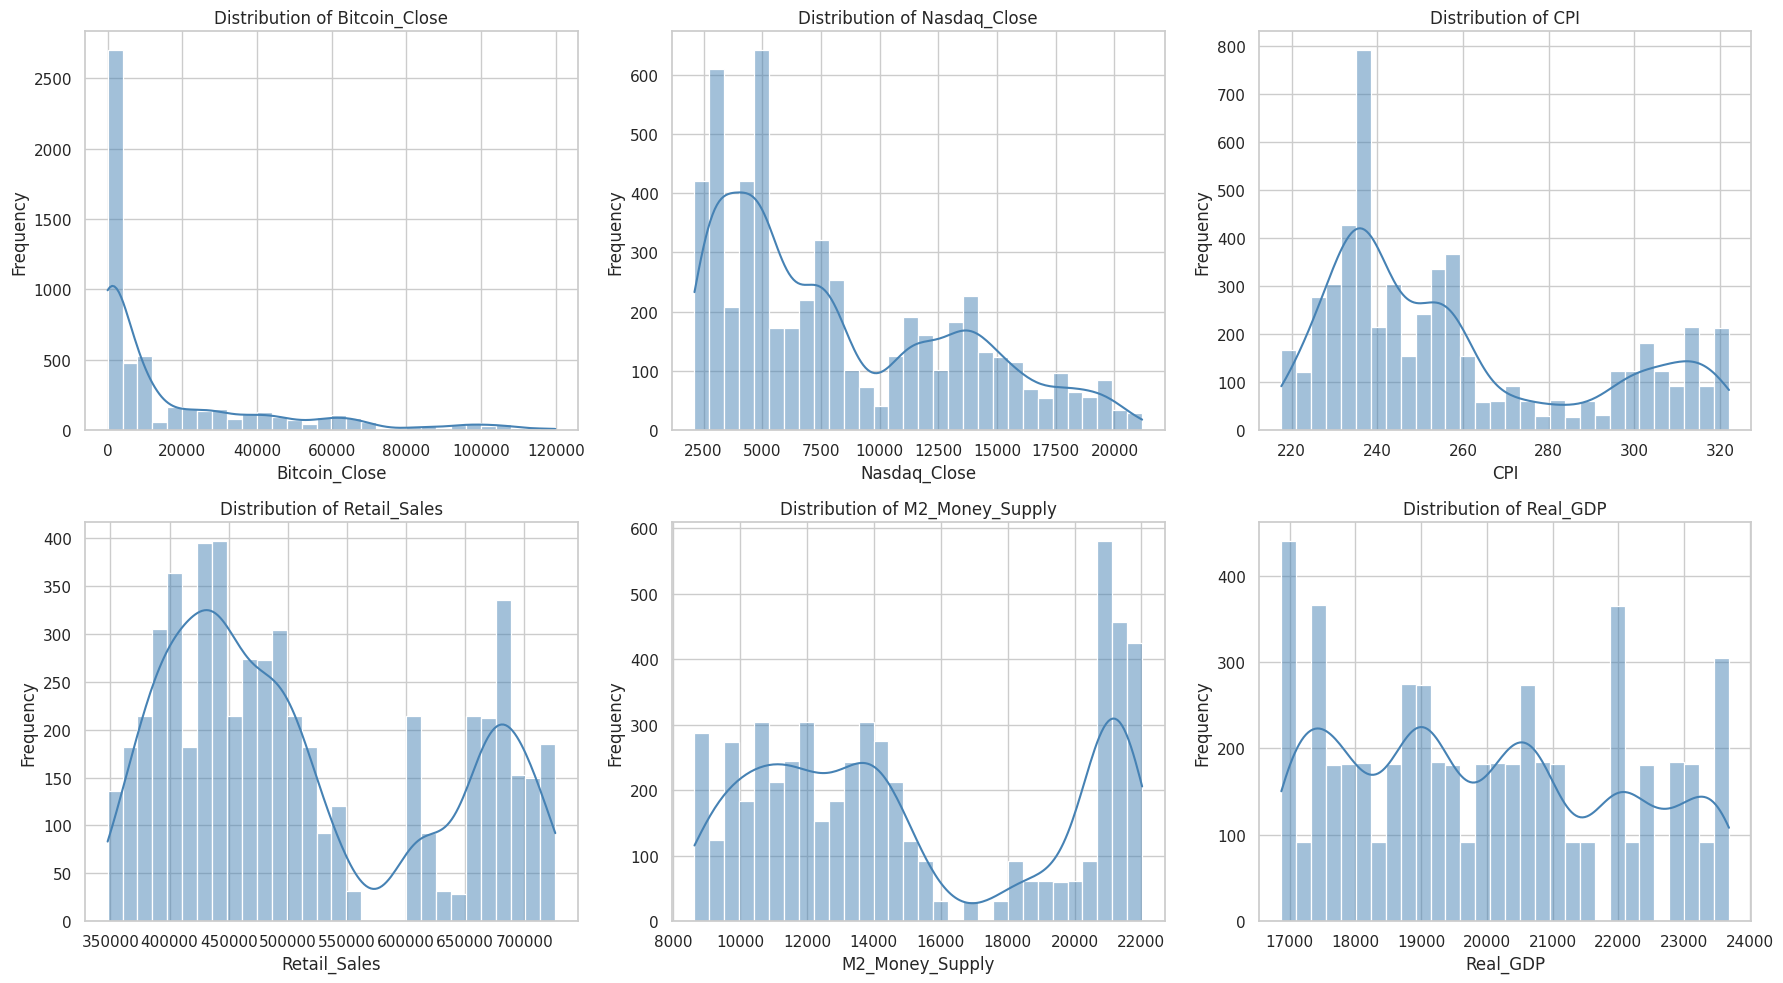

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
import math
import os
os.makedirs("outputs/datasets/figs", exist_ok=True)

numeric_cols = df_feat_eng.select_dtypes(include='number').columns
num_features = len(numeric_cols)

cols_per_row = 3
num_rows = math.ceil(num_features / cols_per_row)

fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(18, 5 * num_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(data=df_feat_eng, x=col, kde=True, bins=30, color="steelblue", ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

fig.savefig("outputs/datasets/figs/feature_distributions.png", dpi=300)


We can see above that 5 of the 6 features will need transforming.  Real GDP seems reasonable enough to proceed with as is.  We will look to transform the other 5 distributions.

But before this, we will perform some feature engineering on the final dataset.  

Each feature will be shifted by 30 days, essentially allowing the model to review the movements from 30 days ago, which will be useful for the macroeconomic indicators influencing BitCoin.

BitCoin, the target, will be moved forward by 30 days to essentially create a new column containing future BitCoin prices 30 days ahead of the current row.

In [63]:
df_feat_eng['Bitcoin_Close_30'] = df_feat_eng['Bitcoin_Close'].shift(-30)

top_5_features = ['Bitcoin_Close', 'Nasdaq_Close', 'CPI', 'Retail_Sales', 'M2_Money_Supply', 'Real_GDP']

for feature in top_5_features:
    df_feat_eng[f"{feature}_lag30"] = df_feat_eng[feature].shift(30)

df_feat_eng = df_feat_eng.dropna().reset_index(drop=True)

final_features = [f"{f}_lag30" for f in top_5_features]
target = 'Bitcoin_Close_30'

df_feat_eng.head()

,Date,Bitcoin_Close,Nasdaq_Close,CPI,Retail_Sales,M2_Money_Supply,Real_GDP,Bitcoin_Close_30,Bitcoin_Close_lag30,Nasdaq_Close_lag30,CPI_lag30,Retail_Sales_lag30,M2_Money_Supply_lag30,Real_GDP_lag30
0,2010-08-17,0.0655,2209.439941,217.923,349188.0,8688.2,16872.266,0.0604,0.0500,2198.229980,217.605,347612.0,8639.8,16872.266
1,2010-08-18,0.0700,2215.699951,217.923,349188.0,8688.2,16872.266,0.0619,0.0858,2198.229980,217.605,347612.0,8639.8,16872.266
2,2010-08-19,0.0680,2178.949951,217.923,349188.0,8688.2,16872.266,0.0590,0.0808,2222.489990,217.605,347612.0,8639.8,16872.266
3,2010-08-20,0.0667,2179.760010,217.923,349188.0,8688.2,16872.266,0.0610,0.0747,2187.330078,217.605,347612.0,8639.8,16872.266
4,2010-08-21,0.0655,2179.760010,217.923,349188.0,8688.2,16872.266,0.0627,0.0792,2245.889893,217.605,347612.0,8639.8,16872.266


We again check for missing data:

In [64]:
print(df_feat_eng.isnull().sum())

Date                     0
Bitcoin_Close            0
Nasdaq_Close             0
CPI                      0
Retail_Sales             0
M2_Money_Supply          0
Real_GDP                 0
Bitcoin_Close_30         0
Bitcoin_Close_lag30      0
Nasdaq_Close_lag30       0
CPI_lag30                0
Retail_Sales_lag30       0
M2_Money_Supply_lag30    0
Real_GDP_lag30           0
dtype: int64


Now we will apply transformers using a custom function supplied by Code Institute to normalise the distributions of the affected features discussed above.

In [65]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

We will review BitCoin's 30 day adjusted price and apply the best transformer to the remaining features in need of normalisation.

In [66]:
variables_engineering = ['Bitcoin_Close_30']
df_engineering = df_feat_eng[variables_engineering].copy()
df_engineering.head(3)

,Bitcoin_Close_30
0,0.0604
1,0.0619
2,0.0590


* Variable Analyzed: Bitcoin_Close_30
* Applied transformation: ['Bitcoin_Close_30_log_e', 'Bitcoin_Close_30_log_10', 'Bitcoin_Close_30_reciprocal', 'Bitcoin_Close_30_power', 'Bitcoin_Close_30_box_cox', 'Bitcoin_Close_30_yeo_johnson'] 



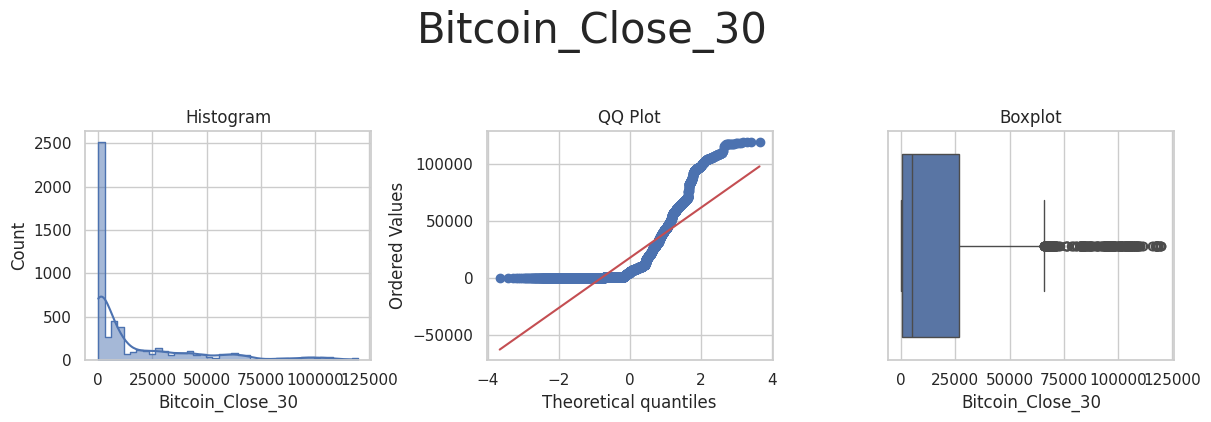

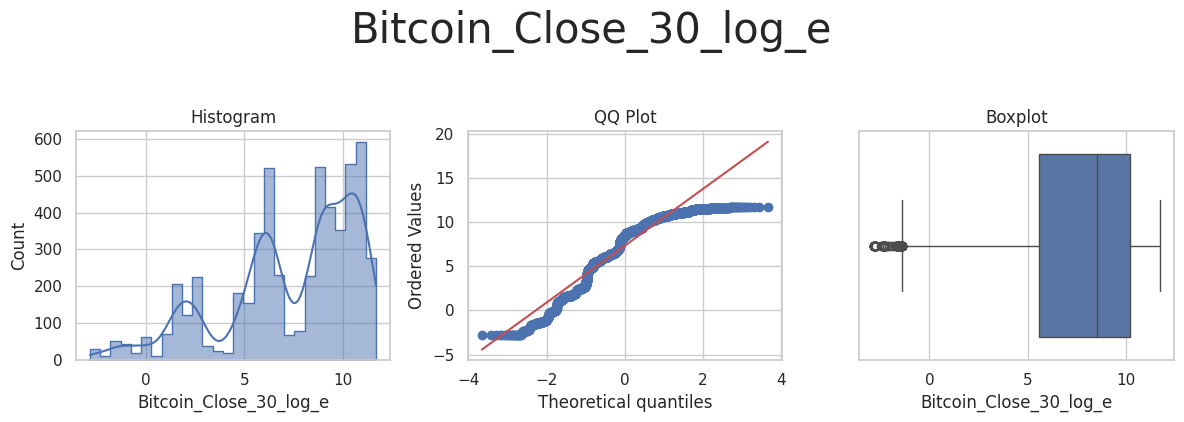

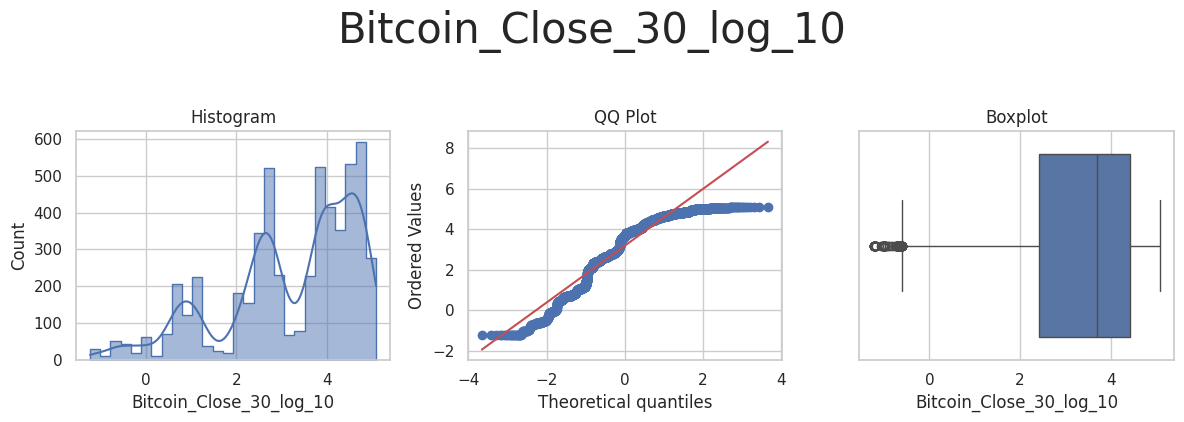

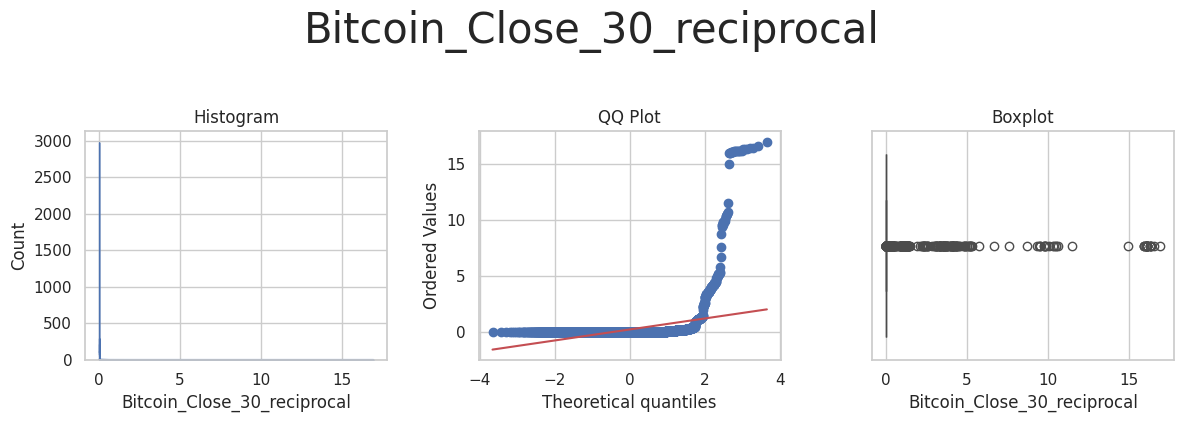

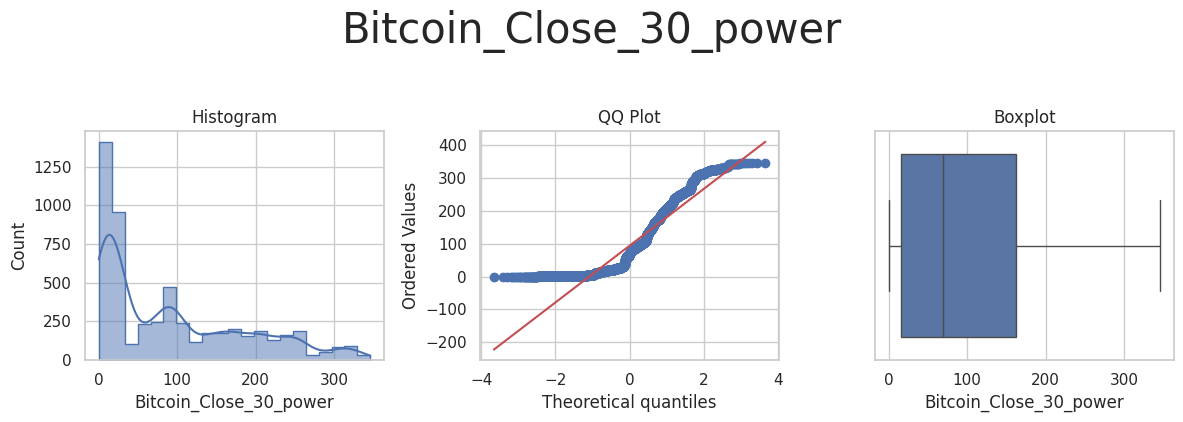

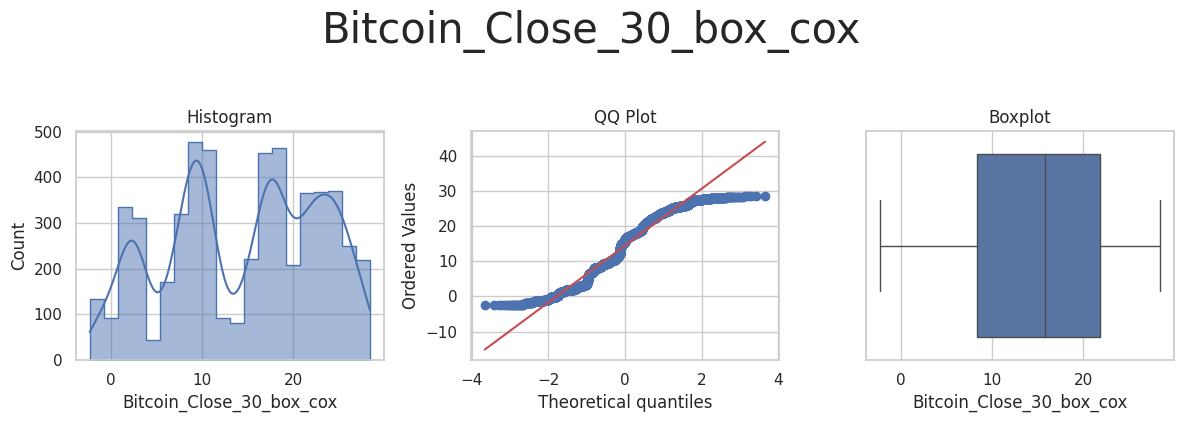

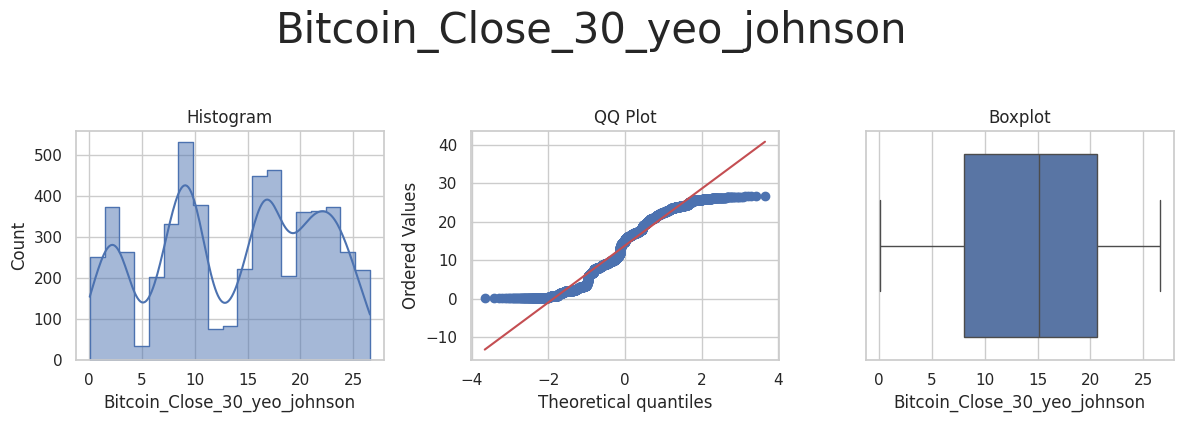

In [67]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

Box Cox looks to be the standout transformer in this case, closely followed by Yeo Johnson.  

We will apply this to the Bitcoin_Close columns, but also to the other features, which are also skewed.

We will ignore Real GDP, which we can see is relatively normal compared to the others from it's histogram.

But first we will save the Lambdas into a .pkl file for use later in the project.

In [68]:
import os
try:
  os.makedirs(name='outputs/transformers')
except Exception as e:
  print(e)

In [69]:
from scipy.stats import boxcox
import pickle

boxcox_features = [
    'Bitcoin_Close', 'Nasdaq_Close', 'CPI', 'Retail_Sales', 'M2_Money_Supply',
    'Bitcoin_Close_30', 'Nasdaq_Close_lag30', 'CPI_lag30',
    'Retail_Sales_lag30', 'M2_Money_Supply_lag30'
]

boxcox_lambdas = {}

for feature in boxcox_features:
    transformed, fitted_lambda = boxcox(df_feat_eng[feature])
    df_feat_eng[f"{feature}_boxcox"] = transformed
    boxcox_lambdas[feature] = fitted_lambda

with open("outputs/transformers/boxcox_lambdas.pkl", "wb") as f:
    pickle.dump(boxcox_lambdas, f)


We will print the Lambda value for BitCoin for use in the next section.

In [70]:
boxcox_lambdas['Bitcoin_Close_30']

0.1347407526217442

We now see that boxcox is applied to BitCoin 30 and the remaining feature, bar Real GDP.

In [42]:
df_feat_eng.head()

,Date,Bitcoin_Close,Nasdaq_Close,CPI,Retail_Sales,M2_Money_Supply,Real_GDP,Bitcoin_Close_30,Bitcoin_Close_lag30,Nasdaq_Close_lag30,...,Bitcoin_Close_boxcox,Nasdaq_Close_boxcox,CPI_boxcox,Retail_Sales_boxcox,M2_Money_Supply_boxcox,Bitcoin_Close_30_boxcox,Nasdaq_Close_lag30_boxcox,CPI_lag30_boxcox,Retail_Sales_lag30_boxcox,M2_Money_Supply_lag30_boxcox
0,2010-08-17,0.0655,2209.439941,217.923,349188.0,8688.2,16872.266,0.0604,0.0500,2198.229980,...,-2.278854,7.643138,0.247176,0.876783,5.343939,-2.337057,7.673381,0.248948,0.889244,5.034549
1,2010-08-18,0.0700,2215.699951,217.923,349188.0,8688.2,16872.266,0.0619,0.0858,2198.229980,...,-2.232727,7.645926,0.247176,0.876783,5.343939,-2.320223,7.673381,0.248948,0.889244,5.034549
2,2010-08-19,0.0680,2178.949951,217.923,349188.0,8688.2,16872.266,0.0590,0.0808,2222.489990,...,-2.252902,7.629449,0.247176,0.876783,5.343939,-2.353098,7.684294,0.248948,0.889244,5.034549
3,2010-08-20,0.0667,2179.760010,217.923,349188.0,8688.2,16872.266,0.0610,0.0747,2187.330078,...,-2.266292,7.629815,0.247176,0.876783,5.343939,-2.330280,7.668439,0.248948,0.889244,5.034549
4,2010-08-21,0.0655,2179.760010,217.923,349188.0,8688.2,16872.266,0.0627,0.0792,2245.889893,...,-2.278854,7.629815,0.247176,0.876783,5.343939,-2.311388,7.694708,0.248948,0.889244,5.034549


We create a separate dataframe of Box Cox figures and we will split our data into Train and Test based off this dataframe.

In [43]:
df_box_cox = df_feat_eng[
    [
        'Date',
        'Bitcoin_Close_boxcox',
        'Nasdaq_Close_boxcox',
        'CPI_boxcox',
        'Retail_Sales_boxcox',
        'M2_Money_Supply_boxcox',
        'Bitcoin_Close_30_boxcox',
        'Nasdaq_Close_lag30_boxcox',
        'CPI_lag30_boxcox',
        'Retail_Sales_lag30_boxcox',
        'M2_Money_Supply_lag30_boxcox',
        'Real_GDP',
        'Real_GDP_lag30'
    ]
]

In [44]:
df_box_cox.head()

,Date,Bitcoin_Close_boxcox,Nasdaq_Close_boxcox,CPI_boxcox,Retail_Sales_boxcox,M2_Money_Supply_boxcox,Bitcoin_Close_30_boxcox,Nasdaq_Close_lag30_boxcox,CPI_lag30_boxcox,Retail_Sales_lag30_boxcox,M2_Money_Supply_lag30_boxcox,Real_GDP,Real_GDP_lag30
0,2010-08-17,-2.278854,7.643138,0.247176,0.876783,5.343939,-2.337057,7.673381,0.248948,0.889244,5.034549,16872.266,16872.266
1,2010-08-18,-2.232727,7.645926,0.247176,0.876783,5.343939,-2.320223,7.673381,0.248948,0.889244,5.034549,16872.266,16872.266
2,2010-08-19,-2.252902,7.629449,0.247176,0.876783,5.343939,-2.353098,7.684294,0.248948,0.889244,5.034549,16872.266,16872.266
3,2010-08-20,-2.266292,7.629815,0.247176,0.876783,5.343939,-2.330280,7.668439,0.248948,0.889244,5.034549,16872.266,16872.266
4,2010-08-21,-2.278854,7.629815,0.247176,0.876783,5.343939,-2.311388,7.694708,0.248948,0.889244,5.034549,16872.266,16872.266


Lets review the distributions on the box cox features:

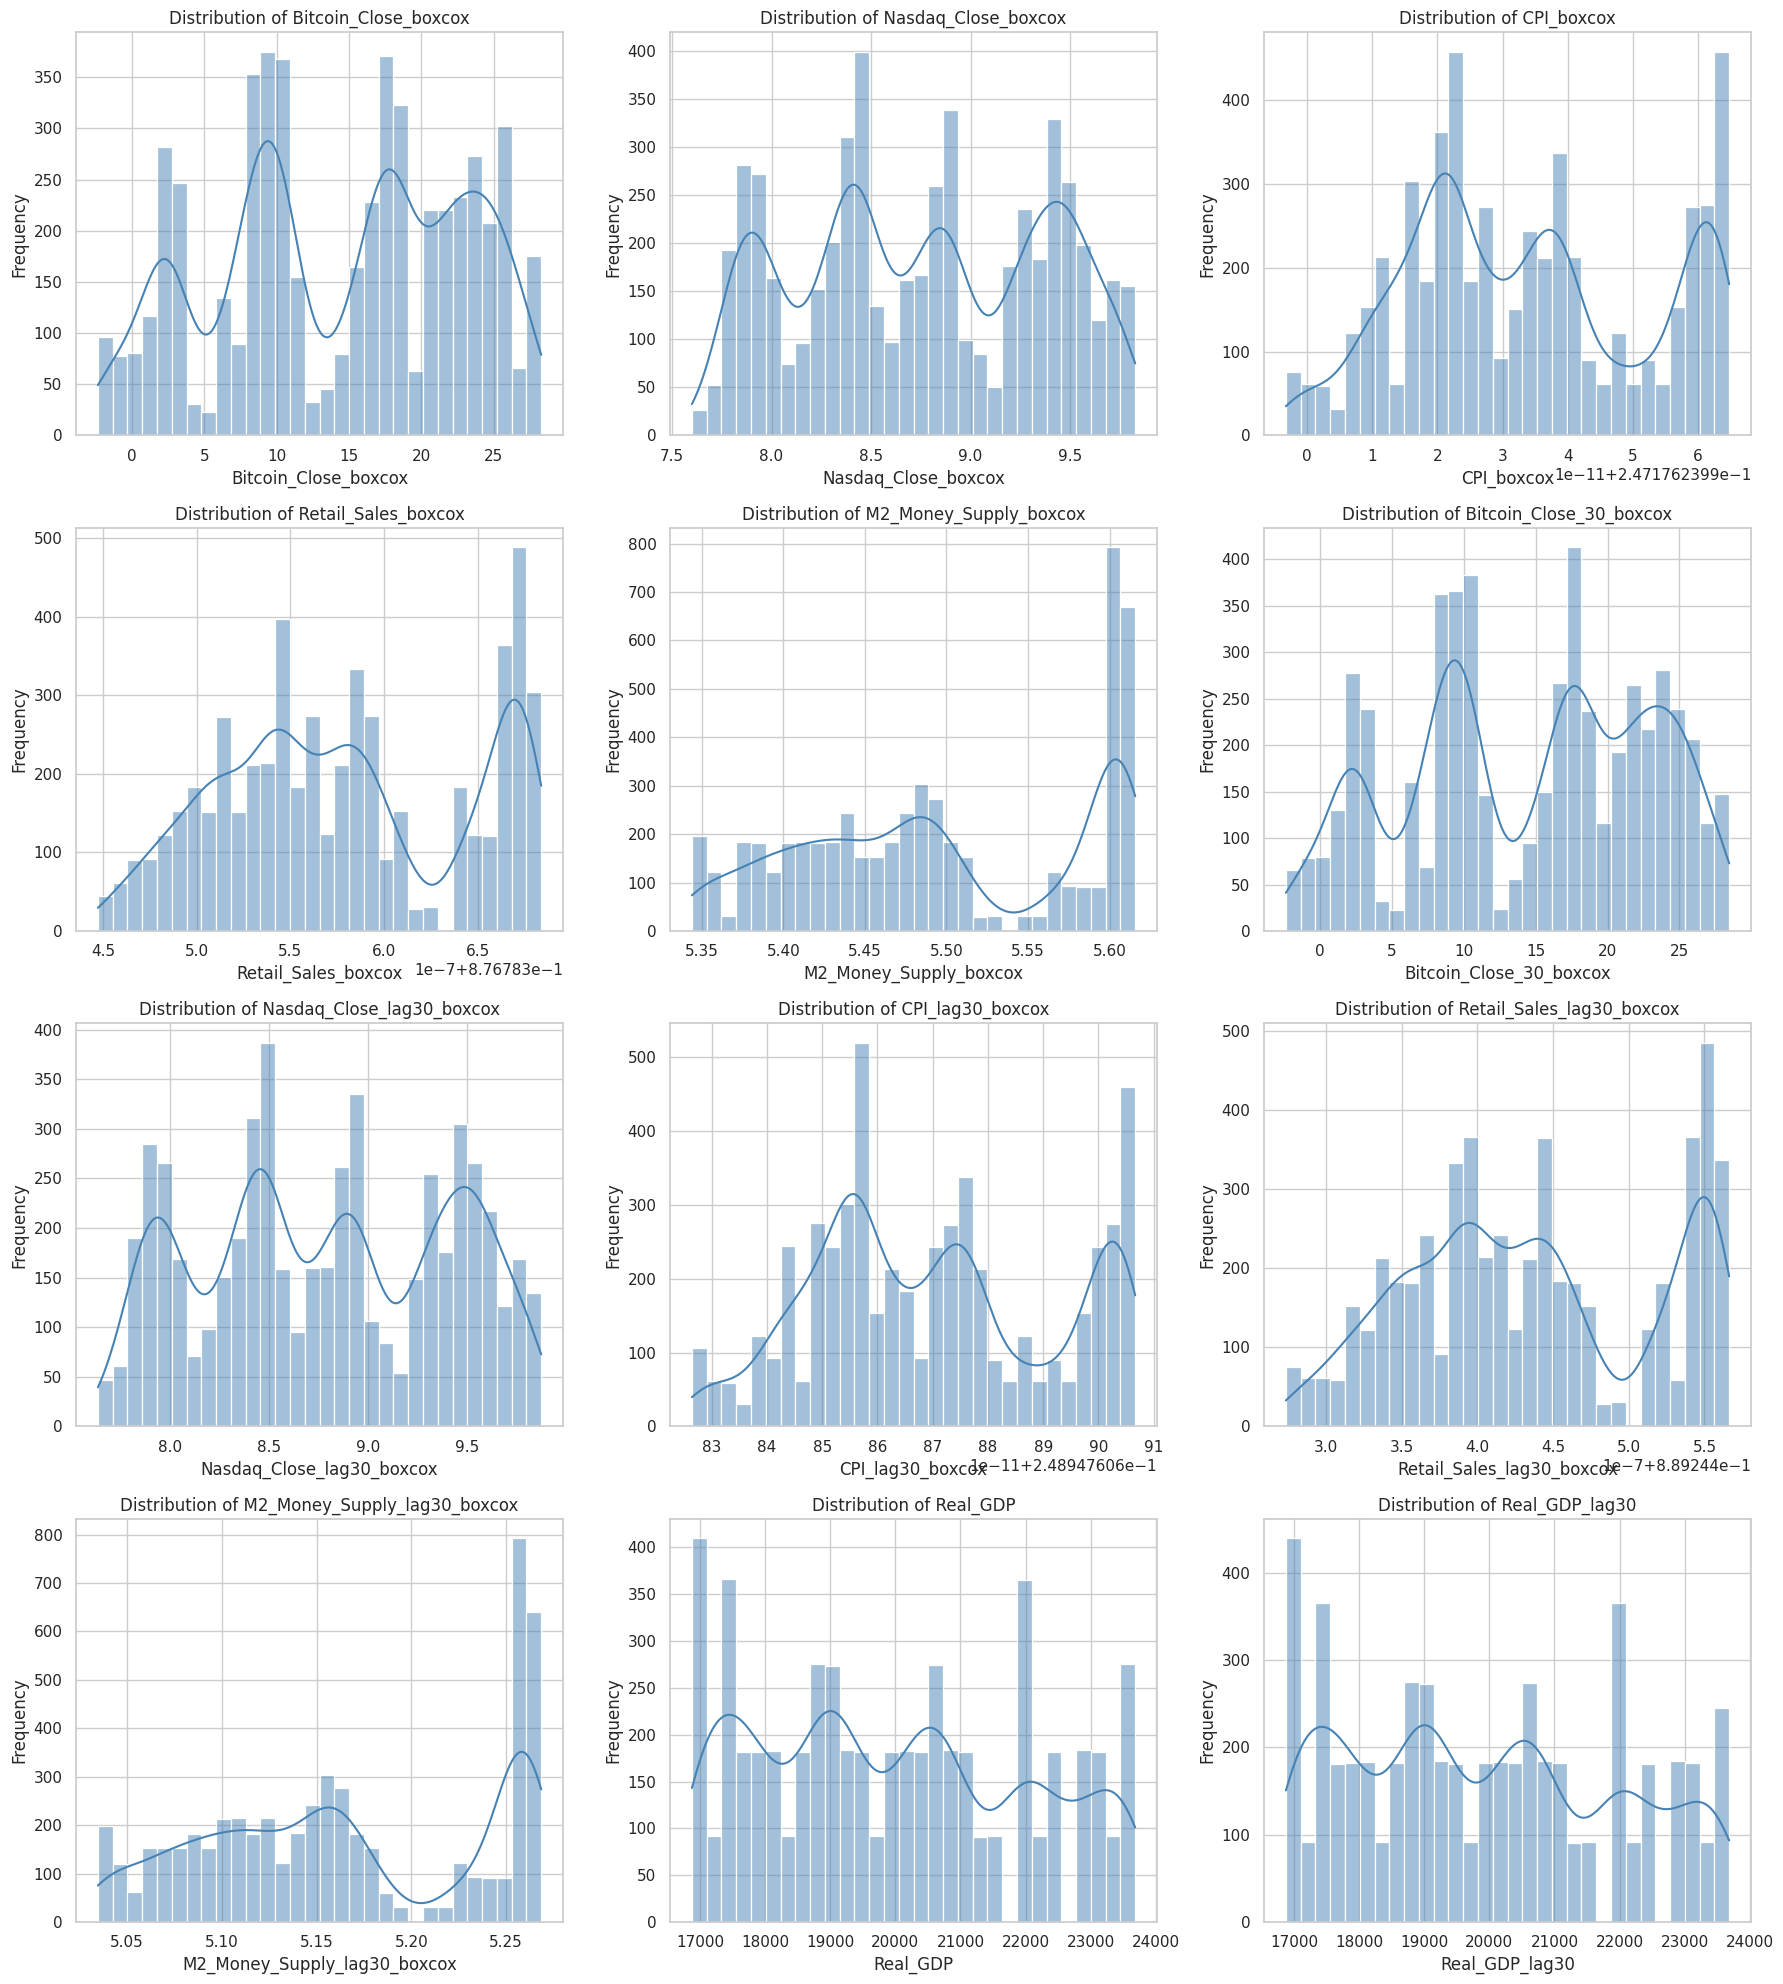

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
import math
import os
os.makedirs("outputs/datasets/figs", exist_ok=True)

numeric_cols = df_box_cox.select_dtypes(include='number').columns
num_features = len(numeric_cols)

cols_per_row = 3
num_rows = math.ceil(num_features / cols_per_row)

fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(18, 5 * num_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(data=df_box_cox, x=col, kde=True, bins=30, color="steelblue", ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

fig.savefig("outputs/datasets/figs/feature_distributions_boxcox.png", dpi=300)

---

# Push Train and Test datasets to the repo

Review the Box Cox dataframe:

In [46]:
df_box_cox.head()

,Date,Bitcoin_Close_boxcox,Nasdaq_Close_boxcox,CPI_boxcox,Retail_Sales_boxcox,M2_Money_Supply_boxcox,Bitcoin_Close_30_boxcox,Nasdaq_Close_lag30_boxcox,CPI_lag30_boxcox,Retail_Sales_lag30_boxcox,M2_Money_Supply_lag30_boxcox,Real_GDP,Real_GDP_lag30
0,2010-08-17,-2.278854,7.643138,0.247176,0.876783,5.343939,-2.337057,7.673381,0.248948,0.889244,5.034549,16872.266,16872.266
1,2010-08-18,-2.232727,7.645926,0.247176,0.876783,5.343939,-2.320223,7.673381,0.248948,0.889244,5.034549,16872.266,16872.266
2,2010-08-19,-2.252902,7.629449,0.247176,0.876783,5.343939,-2.353098,7.684294,0.248948,0.889244,5.034549,16872.266,16872.266
3,2010-08-20,-2.266292,7.629815,0.247176,0.876783,5.343939,-2.330280,7.668439,0.248948,0.889244,5.034549,16872.266,16872.266
4,2010-08-21,-2.278854,7.629815,0.247176,0.876783,5.343939,-2.311388,7.694708,0.248948,0.889244,5.034549,16872.266,16872.266


Sort by date

In [47]:
df_box_cox["Date"] = pd.to_datetime(df_box_cox["Date"])
df_box_cox = df_box_cox.sort_values("Date")

Save the Box Cox transformed dataset:

In [51]:
import os
os.makedirs("outputs/datasets/final_features", exist_ok=True)

df_box_cox.to_pickle("outputs/datasets/final_features/BtcFinalFeatures_lag_boxcox.pkl")

Create the Outputs folder and save the Train and Test datasets:

In [52]:
import os
try:
  os.makedirs(name='outputs/datasets/train_test_initial')
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/datasets/train_test_initial'


Split the dataset into Train and Test

In [53]:
from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(
    df_box_cox.drop(['Bitcoin_Close_30_boxcox', 'Date'], axis=1),
    df_box_cox['Bitcoin_Close_30_boxcox'],
    test_size=0.2,
    shuffle=False,
    random_state=0
)

print(f"features_train shape: {features_train.shape} \nfeatures_test shape: {features_test.shape}")
print(f"target_train shape: {target_train.shape} \ntarget_test shape: {target_test.shape}")


features_train shape: (4347, 11) 
features_test shape: (1087, 11)
target_train shape: (4347,) 
target_test shape: (1087,)


Perform a final check on the train and test datasets for missing data

In [54]:
def check_missing_values(X_train, X_test, y_train, y_test):
    print('Missing Values Summary:\n')
    for name, df in zip(
        ['features_train', 'features_test', 'target_train', 'target_test'],
        [X_train, X_test, y_train, y_test]
    ):
        print(f"{name}:")
        print(df.isnull().sum())
        print()

check_missing_values(features_train, features_test, target_train, target_test)

Missing Values Summary:

features_train:
Bitcoin_Close_boxcox            0
Nasdaq_Close_boxcox             0
CPI_boxcox                      0
Retail_Sales_boxcox             0
M2_Money_Supply_boxcox          0
Nasdaq_Close_lag30_boxcox       0
CPI_lag30_boxcox                0
Retail_Sales_lag30_boxcox       0
M2_Money_Supply_lag30_boxcox    0
Real_GDP                        0
Real_GDP_lag30                  0
dtype: int64

features_test:
Bitcoin_Close_boxcox            0
Nasdaq_Close_boxcox             0
CPI_boxcox                      0
Retail_Sales_boxcox             0
M2_Money_Supply_boxcox          0
Nasdaq_Close_lag30_boxcox       0
CPI_lag30_boxcox                0
Retail_Sales_lag30_boxcox       0
M2_Money_Supply_lag30_boxcox    0
Real_GDP                        0
Real_GDP_lag30                  0
dtype: int64

target_train:
0

target_test:
0



Check the timeframe of train and test sets.

In [55]:
print("Train start:", df_box_cox['Date'].iloc[features_train.index[0]])
print("Train end:", df_box_cox['Date'].iloc[features_train.index[-1]])
print("Test start:", df_box_cox['Date'].iloc[features_test.index[0]])
print("Test end:", df_box_cox['Date'].iloc[features_test.index[-1]])

Train start: 2010-08-17 00:00:00
Train end: 2022-07-11 00:00:00
Test start: 2022-07-12 00:00:00
Test end: 2025-07-02 00:00:00


Save each of the files individually:

In [56]:
features_train.to_csv("outputs/datasets/train_test_initial/features_train.csv", index=False)

In [57]:
features_test.to_csv("outputs/datasets/train_test_initial/features_test.csv", index=False)

In [58]:
target_train.to_csv("outputs/datasets/train_test_initial/target_train.csv", index=False)

In [59]:
target_test.to_csv("outputs/datasets/train_test_initial/target_test.csv", index=False)

### We can now proceed to workbook 4 - Modeling and Evaluation